In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import time
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'scripts'))  # nopep8

# from close_loop_anesth.loop import perform_simulation
from close_loop_anesth.loop_regressors import perform_simulation
# from close_loop_anesth.experiments import auto_tune_pid
from create_param import load_mekf_param, load_mhe_param
from close_loop_anesth.utils import custom_disturbance
from close_loop_anesth.experiments import compute_cost


In [7]:
study_name = 'PID_training_ok'

# Load study
with open(f'data/logs/{study_name}.json', 'r') as f:
    logs = json.load(f)

# Load parameters
best_params = logs['best_params']
best_params['ratio'] = 2
best_params['Ti_1'] = 5

age = 60
height = 165
weight = 60
gender = 0


In [8]:
best_params

{'Kp_1': 0.03595274472041538,
 'Ti_1': 5,
 'Td_1': 8.234817274369249,
 'Kp_2': 0.04035828627430295,
 'Ti_2': 519.891926052166,
 'Td_2': 3.817770126452978,
 'ratio': 2}

In [9]:
start_time = time.time()


results = perform_simulation([age, height, weight, gender],
                             'total',
                             'PID',
                             best_params,
                             None,
                             random_bool = [True, True],
                             bool_noise=True)

print(f"Simulation time: {time.time() - start_time:.2f} s")

Simulation time: 16.91 s


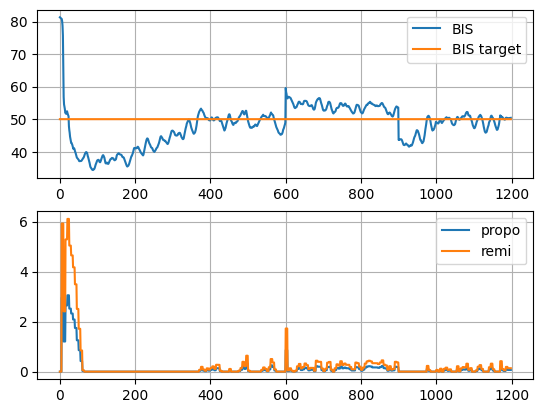

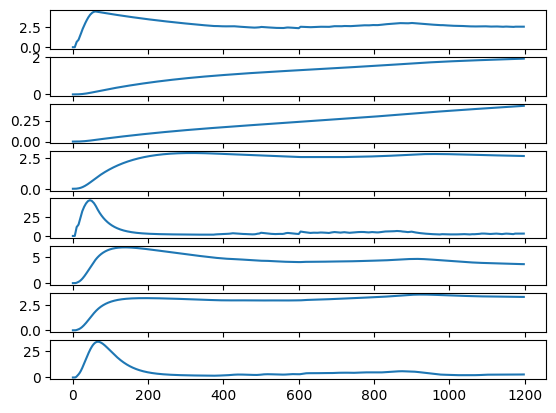

In [10]:
plt.subplot(2, 1, 1)
plt.plot(results['Time'], results['BIS'], label='BIS')
plt.plot(results['Time'], results['BIS']*0 + 50, label='BIS target')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(results['Time'], results['u_propo'], label='propo')
plt.plot(results['Time'], results['u_remi'], label='remi')
plt.legend()
plt.grid()

plt.show()

# plot states
x = results['x'].values
for i in range(8):
    plt.subplot(8, 1, i+1)
    x_i = [x_j[i] for x_j in x]
    plt.plot(results['Time'], x_i, label=f'x{i}')